# Basin Scale Vegetation Vulnerability

Derived from the MDBA BWS Vulnerabilities Project

## Data Inputs

 1. Australian National Aquatic Ecosystem (ANAE) mapping  v3 - The ANAE identifies different vegetation types and provides the spatial units used to summarise other data. Polygons < 1 Ha are removed as they are too small to meet the reliability requirements of the WIT tool and MODIS derived NDVI.  
 1. Geosciences Australia Wetland Insights Tool (WIT) - WIT data observations for all ANAE polygons > 1 Ha in the MDB 1986-present.  Raw data supplied by Geosciences Australia for individual observation dates through the Landsat Record summarised into daily, yearly, all-time and inundation event statistics (a separate jupyter notebook)
 1. Normalized Difference Vegetation Index (NDVI) - Average NDVI per ANAE polygon per year 1986-present calculated using google earth engine reducer: shared code: <https://github.com/Flow-MER/GoogleEarthEngine_scripts>
 1. Root Zone Soil Moisture (Australian Water Outlook) - Mean root zone soil moisture per ANAE polygon per year was generated using ArcGIS but there are many ways to calculate the annual average per polygon from the AWO netcdf   <https://awo.bom.gov.au/products/historical/soilMoisture-rootZone>
 1. Stress thresholds for vegetation based on durations since last inundation for different functional groups that were identified by experts are coded directly into this Jupyter Notebook

## Data Outputs

This notebook writes the various metric to the working directory in tabular format csv files (spatial units in rows, years in columns) that can be read by Microsoft Excel.  Baseline values and scores are added to the tables as additional columns. There are a **lot** of output files included for spatial scales that were not included in the project report but may be useful for other investigations or to inform water planning at those locations (e.g. DIWA and Ramsar sites)

Output files for habitat metrics follow the naming convention: {metric}_{aggregator}_{year_window_width}yr_condition.csv
e.g.  pv_median_DIWA_5yr_condition.csv  is the median "pv" (green fractional cover) with ANAE polygons aggregated to larger DIWA wetland scales using a 5-year moving window in which to calculate rates of change.  

*NOTE:  The outputs generated from this notebook will vary from the report because this code has removed the MDBA Stand Condition tool inputs and made improvements to the NDVI inputs

### Mapping the outputs

* Patterns can be visualised in GIS by joining the output files to the relevant spatial layers.  Many of the vegetation maps in the report used the ANAE polygons scale to visualise the patterns - this was done by joining **FINAL_BWSVulnerability_vegetation_ANAE.csv** to the **ANAEv3** using the **UID** polygon identifier.  Mapping whole Valley aggregated scores would be done by joining **FINAL_BWSVulnerability_vegetation_Valley.csv** to **BWSRegions.shp** using the **BWS_Region**.

## Processing Environment

For the project the analysis was conducted in the python processing environment of ArcGIS Pro 3.0 but were coded to use common open source python data processing libraries (Geopandas, Pandas, numpy) that should enable the analysis to be repeated in most environments.
Note the code produces many more tables of output data than are required because it calculates parameters for multiple spatial scales.  The BWS Vulnerability Project reports mainly on vegetation outcomes at the scale of MDB Valleys (BWS Vegetation Regions). Outputs are also generated for Ramsar sites, MDBA Waterbird Areas (the "dirty thirty" polygons), and individual ANAE polygons.

## Repeating or extending the analysis to additional years of data

Extending the analysis requires:

1. collating new data and appending to the current 1986-2024 source files
1. edit the definition of the **alltime** variable to extend past 2024.
1. re-run the notebook

Source data comes from a variety of places and requires a different technologies to assemble as outlined above.  The current source files should be used as the template to append to,  which should ensure the updated files will run with this workbook.  There is some additional code built into the workbook to re-build spatial relationships among data

The code was built to test the method within the confines of a project so it isn't always pretty.    If the logic is not clear please refer to the report and reach out to the report authors with questions.

***

# Contact

* Dr Shane Brooks

* <https://brooks.eco>


# Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 


In [1]:

import os
import sys
#sys.path.append("D:\Tools\Python\arcgispro-py3-clone-new\Library\bin")
#os.environ['GDAL_DATA'] = 'C:/Program Files/ArcGIS/Pro/Resources/pedata/gdaldata'
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm.notebook import tqdm
from osgeo import gdal

#allow plots within the notebook
%matplotlib inline

ModuleNotFoundError: No module named '_gdal'


# User Defined Parameters

In [2]:
#set the path to the spatial data (shape files)
spatial_path = 'D:/CSIRO_Ramsar_Climate_Change_Vulnerability/data/spatial'


#set the path to the data input files
data_path = 'D:/CSIRO_Ramsar_Climate_Change_Vulnerability/data/input'

#  set the working directory
working_directory = 'D:/CSIRO_Ramsar_Climate_Change_Vulnerability/data/output'


# change to the user specified working directory so the worker gets written to the correct location
os.chdir(working_directory)
cwdpath = os.getcwd()

In [3]:
# initialise data stores  (names are data frames used in the code)
# this allows cells in the notebook to be re-run quickly without re-reading all the iput data multiple times when we dont have to

ANAE = None
DTwaterbirds = None
DIWA = None
Valley = None
Ramsar = None
wb = None
analogue = None

wit_yearly = None
tsli_master = None
idf_master = None
ndvi = None
soilmoisture_df = None
TSC_df = None

In [4]:
#define year ranges used by the method

alltime = list(range(1987, 2021)) #2021 was the last year with complete data  1986 is excluded as it has incomplete data
millennium_drought = list(range(2001, 2010))  #excludes 2010 because last year in a range is not included
#yearcols is a dictionary to translate numberic year column totals of pivot tables into strings as required for shapefiles and csv headers
yearcols = {y: 'y'+str(y) for y in alltime}

#VEGETATION
veg_window_width = 5  # veg condition/stress is averaged over a moving 5 year window up to a given year
veg_trend_width = 2   # veg metric trends are measured in the most recent 2 years leading up to a given year



#Vegetation thresholds from Cherie Campbell noting that some ranges are imprecise and have gaps.  

#the three bins are defined in python using three numbers [0. threshold#1, threshold2]

#and scored as:  0 > LOW > threshold#1 > MEDIUM > threshold#2 > HIGH 


#Vegetation stress thresholds based on the time-since-last-inundation (tsli)
#Threshold scores are set for three bins (LOW, MEDIUM and HIGH stress)
vegetation_tsli_stress_thresholds = {
    'river red gum swamps and forests': [0, 730, 1825], # RRG swamps forests and woodlands 1-2 years, 3-4 years, ≥ 5 years
    'river red gum woodland': [0, 1460, 2555], # RRG swamps forests and woodlands 1-2 years, 5 years, ≥ 7 years
    'black box': [0, 1460, 2555], # Black box, 3 – 4 years, 5 – 6 years, ≥ 7 years
    'cooba': [0, 1460, 2555], # 1-2 years, 5 years, ≥ 7 years
    'coolibah': [0, 3650, 7300], # Coolibah, 10 years, 20 years, > 20 years
    'lignum': [0, 1095, 2555], # Lignum, 3 years, 4 years, ≥ 7 years
    'shrubland': [0, 1095, 3650], # chenopods/shrubland, 3 years, 4 years, ≥ 10 years
    'submerged lake': [0, 90, 120], # Submerged vegetation, < 3 months, 3 – 4 months, > 4 months
    'tall reed beds': [0, 365, 730 ], # Tall reeds, < 1 year, 1 – 2 years, > 2 years
    'grassy meadows': [0, 240, 300], # Grassy meadows, < 8 months, 8 – 10 months, > 10 months
    'herbfield': [0, 365, 1460], # Herb fields, 1 year, 2 – 4 years, > 4 years
    'clay pan': [0, 3650, 7300] #not vegetated but used for waterbirds  10 years, 20 years, > 20 years
}

# Waterbird stress metric based on the time-since-last-inundation (tsli) of wetland vegetation the waterbirds depend on
# Threshold scores are set for three bins (LOW, MEDIUM and HIGH stress)
# the alignment of waterbirds to habitat types is explained in the roport and is defined in the dictionary below waterbird_dom_habitats
waterbird_habitat_stress_thresholds = {
     'river red gum swamps and forests': [0, 365, 1460], # <1 year, 1-4 years, ≥ 5 years
     'river red gum woodland': [0, 365, 1460], # <1 year, 1-4 years, ≥ 5 years
     'black box': [0, 365, 1460], # <1 year, 1-4 years, ≥ 5 years
     'cooba': [0, 1460, 2555], # 1-2 years, 5 years, ≥ 7 years
     'shrubland': [0, 1095, 3650], # chenopods/shrubland, 3 years, 4 years, ≥ 10 years
     'coolibah': [0, 365, 1460], # <1 year, 1-4 years, ≥ 5 years
     'lignum': [0, 365, 1460], # <1 year, 1-4 years, ≥ 5 years
     'submerged lake': [0, 365, 1095], # <1 year, 1-3 years, ≥ 3 years
     'tall reed beds': [0, 365, 1460], # <1 year, 1-4 years, ≥ 5 years
     'grassy meadows': [0, 365, 1460], # <1 year, 1-4 years, ≥ 5 years
     'herbfield': [0, 365, 1460], # <1 year, 1-4 years, ≥ 5 years
     'clay pan': [0, 365, 1460], # <1 year, 1-4 years, ≥ 5 years
}

# Define a dictionary that identifies the importnat dominant ecosytem type groups for different
# waterbird functional groups. This is used to take vegetation/habitat metrics to waterbird groups
    
waterbird_dom_habitats = {
    'Aerial_divers': ['submerged lake'],
    'Colonial_nesters':['river red gum swamps and forests'],
    'Cryptic_waders': ['herbfield', 'tall reed beds'],
    'Diving_swimmers': ['river red gum swamps and forests'],
    'Filtering': ['river red gum swamps and forests'],
    'Grazing_swimmers': ['river red gum swamps and forests'],
    'Shorebirds': ['submerged lake']
}   
    


# Function definitons

In [5]:
    
def pivot_year(df, wit_metric, pkey='UID'):
    """
        Pivot the input data to a dataframe with years as column headers
        calculate the mean and stddev for the baseline years =1989-2022 excluding the millinium drought
        
        count =  number of years with waterbird counts
        baseline = mean of baseline years
        max = maximum value for baseline period
        median = median value for baseline period
        mad =  median absolute deviation baseline
               mad is a non-parametric standard deviation used with the
               waterbird data because there are lots of spatial units with no or few count records
    '''
        
        
    """
    allyears = df['year'].unique().tolist()
    baseline = [y for y in allyears if y not in millennium_drought]   #alltime excluding the millennium_drought
    
    
    pivot = df.pivot(index = pkey, columns='year', values=wit_metric )
        #count of how many years have data
    pivot['count'] = pivot.count(axis=1, numeric_only=True)

    #baseline = average metric for baseline years 
    pivot['baseline'] = pivot[baseline].mean(axis=1, numeric_only=True)

    #stddev = stdev in metric for baseline years
    pivot['stddev'] = pivot[baseline].std(axis=1, numeric_only=True)
    #pivot['dev'+str(recent[-1])] = ((pivot[recent[-1]]-pivot['baseline'])/pivot['stddev'])+0
    
    #baseline = average metric for baseline years 
    pivot['max'] = pivot[baseline].max(axis=1, numeric_only=True)
    
    
    pivot['median'] = pivot[baseline].median(axis=1, numeric_only=True)

    tmp=pd.DataFrame()
    for y in baseline:
        tmp[y] = abs(pivot['median'] - pivot[y])
    #tmp.to_csv("DEBUG_tmp.csv")
    pivot['mad'] = tmp.median(axis=1, numeric_only=True)

    #deviation from baseline in each of the recent (last 5 years) standardised by the stddev
    #for y in baseline[-5:]:
    #    pivot['cond'+str(y)] = (pivot[y]-pivot['baseline'])/pivot['stddev']  #+0 converts -0 to 0

    #sum negative scores in recent (last 5)    
    #ya = ['status'+str(y) for y in recent[::-1]]
    #pivot['sum5y_neg'] = pivot[ya][pivot[ya] < 0].sum(axis=1, numeric_only=True)
    return pivot

def fn_slope(d):
    """
        calculate the rate of change as the slope through the supplied points
        input is a series of values
        output is the rate of change
    """
    yvalues = d.values
    if len(yvalues) < 2:
        return float('NaN')
    else:
        xvalues = list(range(0,len(yvalues)))
        #standardise xvalues to keeps spread of slope roughly -1 to 1  as number of x values varies
        xmean=np.mean(xvalues)
        xstdev=np.std(xvalues)
        standardised_xvalues = [(x-xmean)/xstdev for x in xvalues]
        return np.polyfit(standardised_xvalues, yvalues, 1)[0].round(4) #slope

def fn_average_trend (df, period, trend_period = None, nobaseline = False):
    """
        calculate the average rate of change within a windows of x years (the trend_period)
    """
    if trend_period is None:
        trend_period = period
    elif len(trend_period) > len(period):
        raise Exception("trend_window_width must be less than or equal to year_window_width")
    #calculate mean and slope of the 5years values difference from baseline standardised by the stddev

    if nobaseline:
        tmp = df[period]
    else:
        tmp = df[period].subtract(df['baseline'], axis=0).div(df['stddev'], axis=0)+0
    #tmp=tmp.dropna()
    tmp=tmp.fillna(0) # sites with no variation (eg always dry have baseline=0, stddev=0 so standardised metric becomes na from divide by zero - recast to zero
    #debug print ('period', period)
    slope = 'Trend'+ str(period[-1])
    ave = 'Ave' + str(period[-1]) #capital A ensures column sorts first
    tmp[ave] = tmp[period].mean(axis=1, numeric_only=True)
    cols = [ave]
    if len(period) > 1:
        #print ('trend_period', trend_period)
        #print(tmp)
        tmp[slope] = tmp[trend_period].apply(fn_slope, axis=1)
        cols.append(slope)
    #debug tmp.to_csv(str(year)+"fn_average_trend_tmp.csv")
    return tmp[cols]

# def aggregate_fields (ANAE, aggshp, aggfield):
#     agg = gpd.read_file(aggshp).to_crs("EPSG:3577")[aggfield + ['geometry']]
#     grp_labels = gpd.sjoin(ANAE, agg, how="left", op='intersects')[['UID', 'ANAE_TYPE','Area_Ha'] + aggfield].set_index('UID')
#     return grp_labels, aggfield

#def aggregate_area_weighted(df, agg, aggfield, ANAE = ANAE, ANAEgrp = [], pkey='UID'):
def aggregate_area_weighted(df, agg, aggfield, ANAEgrp = []):
    """
        Takes parameter values for individual ANAE ecosystem polygons and aggregates the values to larger areas
        using an area weighting.  e.g. to aggregate a metric across all the ANAE polygons within a Ramsar site
        inputs: dataframe of parameter values per ANAE polygon
                a specified aggregator (one or more larger subunits that contain multiple ANAE polygons)
        
        Output is a single metric value for each larger area subunit calcualted the area weighted mean of the ANAE polygons within it
    """
    cols = df.columns.values.tolist()
    #debug df.to_csv("fn_aggregate_area_weighted_df.csv")
    #debug grp_labels.to_csv("fn_aggregate_area_weighted_grp_labels.csv")

    agdf = df.join(agg, how='inner')
    agdf = agdf.replace([np.inf, -np.inf], np.nan)  #there are some stray "inf" values from dividing by very small small stddev -covert to NaN so sum(numeric_only = True) can ignore them

    #debug agdf.to_csv("fn_aggregate_area_weighted_agdf.csv")
    if agg.name == 'ANAE':
        return agdf[['grp'] + cols +['Area_Ha']].set_index('grp', append=True)
    else:
        agdf[cols] = agdf[cols].multiply(agdf['Area_Ha'], axis = 0)
        #debug agdf.to_csv("fn_aggregate_area_weighted_agdftimesArea.csv")
        agg_data = agdf[cols +['Area_Ha']+aggfield+ANAEgrp].groupby(aggfield+ANAEgrp).sum(numeric_only = True)
        #debug agg_data.to_csv("fn_aggregate_area_weighted_agg_data.csv")
        agg_data[cols] = agg_data[cols].div(agg_data['Area_Ha'], axis = 0)
        return agg_data[cols+['Area_Ha']]

def bin_stress_scores(x, params):
    (thresholds, colname) = params
    '''
    bin values into 3,2,1 (low, medium high) = reverse of condition binning 
    applying pre-determined thresholds mapped in tsl_score dict.
    '''
    _bins = thresholds[x['grp'].iat[0]]+[float("inf")]
    #debug print (x['grp'].iat[0],_bins,list(range(len(_bins)-1,0,-1)))
    return pd.cut(x[colname], bins=_bins, right=False, labels=range(len(_bins)-1,0,-1)).astype('float') #return as float instead of category so we can multiply by area to scale up

def rename_stats_columns(c, metric_name):
    '''
        a clumsy routine in ever evolving code to remname column headers in the data frame
    '''
    c = c.replace('Ave',metric_name)
    c = c.replace('Trend','T'+metric_name)
    return c

def deviation_from_baseline(df, metric, year_window_width, trend_window_width, nobaseline = False):
    '''
        calculate the deviation from the baseline in each year of the data frame
        
        append also the Trend in the deviations over the trend_window_width with prefix "T" on columns headings
        
        append also the SUM deviation over the year_window_width with prefix "sum" on columns headings (e.g. sum of the preceeding 5 years)
    '''
    allyears = df['year'].unique().tolist()
    baseline = [y for y in allyears if y not in millennium_drought]   #alltime excluding the millennium_drought
    _years=range(allyears[0]+year_window_width-1,allyears[-1]+1)
    metric_name = metric.replace('+','').lower()
    
    pivot = pivot_year(df, metric, pkey).round(4)
    pivot.to_csv(f"BWS_pivot_{metric}.csv")
    dfs = []
    for p, year in enumerate(tqdm(_years, desc = f"{metric} in {year_window_width}y window, trend over {trend_window_width}y:")):
        period = list(range(year-year_window_width+1,year+1))
        trend_period = period[-trend_window_width:]
        stats_df = fn_average_trend(pivot, period, trend_period, nobaseline = nobaseline)
        #debug stats_df.to_csv(str(year)+"testmetrics.csv")
        #debug print(year,stats_df)
        ave = stats_df.columns.values.tolist()[0]
        #if we want to score before aggregating
        #stats_df['sc'+metric+str(year)] = pd.cut(stats_df[ave], bins = _bins, labels = range(1,len(_bins))).astype('float') #float not default category so can be aggregated
        if len(stats_df.columns) > 1:
            trend = stats_df.columns.values.tolist()[1]
            stats_df['sum'+metric_name+str(year)] = stats_df.sum(axis=1)
            #if we want to score before aggregating
            #stats_df['scT'+metric+str(year)] = pd.cut(stats_df[ave], bins = _bins, labels = range(1,len(_bins))).astype('float') #float not default category so can be aggregated           
        dfs.append(stats_df)
    #aggregate all the metrics into a single data frame
    metrics_df = pd.concat(dfs, axis=1).sort_index(axis=1)
    metrics_df = metrics_df.rename(columns = {c: rename_stats_columns(c.strip(), metric_name) for c in metrics_df.columns})
    return metrics_df

def append_metric_scores(df, col_list, _bins, _labels):
    '''
        scores the input data frame into bins and appends the scores for each year as
        additonal columns added to the right edge of the data frame so the data can be easily viewed in Excel
    
    '''
    for col in col_list:
        df['sc'+col] = pd.cut( df[col], bins = _bins, labels = _labels, include_lowest = True).astype('float') #defaults to 'category' so recast to float so scores can be aggregated
    return df

def calc_pivots (df, metrics, year_window_width=5, trend_window_width=None, _bins=[float('-inf'),-1,0,float('inf')], reverse_scores=False, nobaseline=False, tag=''):
    '''
        This brings together some of the code above to
        summarise the metrics in a moving window of multiple years
        (for the BWS vulnerabilities project the veg condition and trend (rate of change) over a
        moving 5 years period was calculated for each year of the data frame
        
        The metrics are then aggregated to the pre-defined larger spatial subunits (Ramsar sites, waterbird breeding sites, valleys)
        
        Pivot tables are written to the working directoy as cvs files for inspection in Excel.
        The pivot tables will also be read in and scored for the final integration of vulnerability metrics
        
        reverse_scores true/false is used to switch the logic for different metrics 
        e.g. more green veg (WIT pv) is good, more bare soil (WIT bs) is bad
    
    ''' 
    
    if trend_window_width is None:
        trend_window_width = year_window_width
    elif trend_window_width > year_window_width:
        raise Exception("trend_window_width must be less than or equal to year_window_width")
    _scores = list(range(1,len(_bins)))
    if reverse_scores: _scores=_scores[::-1]
    wit={}
    for metric in metrics:
        metrics_df = deviation_from_baseline(df, metric, year_window_width, trend_window_width, nobaseline = nobaseline)
        print('Aggregate metrics and scores:')
        for ag in aggregators:
            fname = f"{metric}_{ag}_{year_window_width}yr{tag}.csv"
            print (f"     {ag} - {fname}")
            wit[ag] = aggregate_area_weighted(metrics_df, aggregators[ag], aggfield[ag], ANAEgrp = ['grp']).round(4)
            col_list = [c for c in wit[ag].columns.values.tolist() if c != 'Area_Ha']
            wit[ag] = append_metric_scores(wit[ag], col_list, _bins, _scores)
            wit[ag].to_csv(fname)

def standardise (df):
    '''
        Standardises an input data frame to values between 0-1
        used to standardise NDVI from older NOAA AVHRR and newer MODIS
    '''
    dmin = df.min()
    drange = df.max() - dmin
    return df.subtract(dmin).divide(drange)


def standardise_z (df):
    '''
        z-score standardise an input data frame 
        used to standardise NDVI from older NOAA AVHRR and newer MODIS
    '''
    dmean = df.mean()
    dstdev = df.std()
    return df.subtract(dmean).divide(dstdev)


def infill_years(series):
    '''
      used to fill out a series of years when some years are not represented due to missing data
      i.e. wehen there are no waterbird counts for a year in a location
    '''
    indexnames = list(series.index.names)
    #notyear = [x for x in indexnames if x != 'year']
    notyear = ','.join(x for x in indexnames if x != 'year')
    df=pd.DataFrame(series)

    #fill years without breeding with 0
    mux = pd.MultiIndex.from_product([
            fullperiod,
            df.reset_index()[notyear].unique()
            ], names=indexnames)
    return df.reindex(mux).fillna(0)


def get_nearest_distance(left, right, search_distance, name, label):
    """get distance between to features (passed as left and right)"""
    search_area = left.buffer(search_distance)

    data = []
    for i in range(len(search_area)):
        geom = search_area.geometry.iloc[i]
        query = right.sindex.query(geom)
        dist = right.iloc[query].distance(left.geometry.iloc[i])
        min_dist = dist.min()
        if 0 <= min_dist <= search_distance:
            right_idx = dist.idxmin()
            row = [right_idx, right.iloc[right_idx][label], min_dist]
        else:
            #no features within search distance
            row = [-1, float('NaN'), -1]
        data.append(row)
    return pd.DataFrame(data, index = left.index, columns=[name + '_idx', name + '_name', name + '_dist'])

def waterbird_metrics(df, aggregator, breeding=''):
    '''
    summarise various waterbird counts
    Annual waterbird totals are estimated as the larger number of:
        * the maximum count per spatial unit from aerial survey; or
        * the combined aggregate of individual observations
        
    The logic here is that you cant just sum waterbird records because 
    individual ALA obvservations are counting the same individuals as seen in the aerial surveys
    also...  ALA records can also be multiple observations of the same individuals
    
    '''

    big_surveys = ['Murray Icon', 'SEA', 'CLLMM', 'Eastern Australian Survey' , 'Hydrological Indicator Sites']
    indivperANAE = df[~df.cCode.isin(big_surveys)].groupby(['year','ANAE_idx', aggregator, 'grp', 'vName'])['iCount'].max()
    indivperaggregate = indivperANAE.groupby(['year', aggregator, 'grp', 'vName']).sum()
    each_big_surveys_peraggregate = df[df.cCode.isin(big_surveys)].groupby(['year', 'cCode', aggregator, 'grp', 'vName'])['iCount'].sum()
    max_big_surveys_peraggregate = each_big_surveys_peraggregate.groupby(['year', aggregator, 'grp', 'vName']).max()

    indiv = pd.concat([indivperaggregate,max_big_surveys_peraggregate]).groupby(['year', aggregator, 'grp', 'vName']).max()
    grpindiv = indiv.groupby(['year', aggregator, 'grp']).sum()
    
    sr = df.groupby(['year', aggregator])['vName'].nunique()
    grpsr = df.groupby(['year', aggregator, 'grp'])['vName'].nunique()

    indiv.to_csv('indivcount'+aggregator+breeding+'.csv')
    grpindiv.to_csv('grpindiv'+aggregator+breeding+'.csv')
    return indiv, grpindiv, sr, grpsr


def extract_scores (ag, fname, score_field_name):
    '''
        Retrieves the score columns from specified output pivot tables
        and strips off the string prefix from year columns.
        This standardises the format of the different score tables so metrics
        can be summed and counted across groups and features
        with pandas append and groupby functions        
    '''
    #print(f'     Reading scores from {fname}...') #DEBUG
    scores = pd.read_csv(fname, low_memory=False)
    colnames = [f"{score_field_name}{y}" for y in years] 
    scores = scores[aggfield[ag]+['grp']+colnames].set_index(aggfield[ag]+['grp'])
    return scores.rename(columns = {c: c[-4:] for c in scores.columns})

def habitat_to_waterbird_groups (ag, score_df):
    wb_grp_scores = []
    idx =score_df.index.names
    #summed aggregate area per spatial unit needed to to area weighting if a waterbird group is spread across more than one habitat types (Cryptic waders)
    area = aggregators[ag][['Area_Ha']+['grp']+aggfield[ag]].groupby(aggfield[ag]+['grp']).sum()
    #print (area) #DEBUG
    for wb_group in waterbird_dom_habitats:
        
        #get habitat rows from stress_df that correspond to the waterbird group
        grp_df = score_df.iloc[score_df.index.get_level_values('grp').isin(waterbird_dom_habitats[wb_group])].copy()
        cols = grp_df.columns.tolist()
        grp_df =  grp_df.join(area)
        grp_df = grp_df.reset_index()  #removing the index makes it easy to rename the habitats to the waterbird groups
        #rewrite all the selected habitat types to the waterbird group name
        grp_df['grp'] = wb_group
        if len(waterbird_dom_habitats[wb_group]) > 1:
            # combine scores for multiple habitats using area-weighting
            #  print (f'          {waterbird_dom_habitats[wb_group]} assigned to {wb_group} - area weighted average') #DEBUG
            grp_df[cols] = grp_df[cols].multiply(grp_df['Area_Ha'], axis = 0)
            agg_data = grp_df[cols +['Area_Ha']+idx].groupby(idx).sum(numeric_only = True)
            agg_data[cols] = agg_data[cols].div(agg_data['Area_Ha'], axis = 0)
            grp_df = agg_data[cols]  #removes the Area_Ha so it doesnt interfere with rescaling the frames to 0-1 later

        else:
            #print (f'          {waterbird_dom_habitats[wb_group]} assigned to {wb_group}') #DEBUG
            grp_df = grp_df.set_index(idx).drop('Area_Ha', axis=1) #removes the Area_Ha so it doesnt interfere with rescaling the frames to 0-1 later
        wb_grp_scores.append(grp_df)
        #print (grp_df)  #DEBUG
    wb_scores = pd.concat(wb_grp_scores)
    return wb_scores

def normalise_data (df):
    df_min = min(df.min())
    df_max = max(df.max())
    return df.subtract(df_min).divide(df_max-df_min)

def sum_and_normalise_data_weighted (df, max_metric_count):
    '''
        sums the condition/stress scores for each feature in the index and rescales the data
        normalising to range 0-1 allowing for cells with missising data
        rescaled = (sum - count) / (count * number of possible metrics) - count)
    '''
    sum_df = df.groupby(level=df.index.names).sum()
    count_df = df.groupby(level=df.index.names).count()
    return sum_df.subtract(count_df).divide(count_df.multiply(max_metric_count).subtract(count_df))

# Load in the spatial subunits - ANAE and aggregating layers

This block of code is slow to run as it:
1. first reads in the ANAE polygons
2. spatially join the ANAE to multiple data sets with larger-scale subunits to map the aggregations of individual ANAE polgons required to represent larger areas (e.g. Ramsar sites, DIWA wetlands, Valleys

The spatial data is read in once and stored and will not be re-read if the cell is re-run.  If the data needs to be read again either reset the notebook at start again or re-run the cell above that initialises the data stores to NONE.

In [6]:
#name of the unique ID identifying each ANAEv3 polygon is a 9 character geohash 
pkey = 'UID'

#dictionary of the aggregators - for the BWS vulnerabilites project we were interested in scaling up from ANAE polygons to larger subunits including




#DTwaterbirds =  dirty thirty =  MDBA waterbird units
#DIWA = Directory of Important Wetlands 
#Ramsar
#Valleys are valleys used by MDBA uses as "vegetation regions" to guide priority setting in the BWS
#Basin is the whole MDB

#aggfield is the unique identifier for subunits within each of the aggregator data sets
# note for Ramsar sites we can aggregate ANAE polygons to multiple "wetlands" within each ramsar site
aggfield = {
    'ANAE': ['UID'],
    'DTwaterbirds': ['LABEL'],
    'DIWA': ['WNAME'],
    'Ramsar': ['RAMSAR_NAM','WETLAND_NA'],
    'Valley': ['BWS_Region'],
    'Basin' : [],
    'analogue': ['analogue'],
}

#spatial data is read into geopandas data frames  

#if we havn't read the ANAE data in before the do it now reading into a geopandas frame
#for the ANAE we simplify the typology by grouping some of the ANAE ecosystem types with the same dominant vegetation
#e.g. we take black box floodplains and blackbox woodland swamps and combine into a single "black box" class
  
if ANAE is None:
    print ('Reading ANAE...')
    ANAE = gpd.read_file(os.path.join(spatial_path, 'ANAEv3_BWS.shp')).to_crs("EPSG:3577")
    ANAE = ANAE[['UID','ANAE_TYPE','Area_Ha','geometry']]
    
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('river red gum', case=False), 'grp'] = 'river red gum swamps and forests'
    ANAE.loc[(ANAE['ANAE_TYPE'].str.contains('river red gum', case=False)) &
             (ANAE['ANAE_TYPE'].str.contains('woodland', case=False)), 'grp'] = 'river red gum woodland'
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('black box', case=False), 'grp'] = 'black box'
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('coolibah', case=False), 'grp'] = 'coolibah'
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('lignum', case=False), 'grp'] = 'lignum'
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('cooba', case=False), 'grp'] = 'cooba'  ##added for CSIRO climate change
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('F2.4: shrubland riparian zone or floodplain', case=False), 'grp'] = 'shrubland'  ##added for CSIRO climate change
    
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('permanent lake|permanent wetland|aquatic bed', case=False), 'grp'] = 'submerged lake'
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('tall emergent marsh', case=False), 'grp'] = 'tall reed beds'
    ANAE.loc[(ANAE['ANAE_TYPE'].str.contains('grass|meadow', case=False)), 'grp'] = 'grassy meadows'
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('forb marsh|temporary wetland|temporary lake', case=False), 'grp'] = 'herbfield'
    ANAE.loc[ANAE['ANAE_TYPE'].str.contains('clay', case=False), 'grp'] = 'clay pan'
    #setting the names of the data frames is important to permit lookup of appropriate aggregate fields in aggfield dictionary 
    ANAE.name = 'ANAE' #used to area-weight aggregate all ANAE polygons


    


# Load Aggregator shapefiles and use spatial joins to determine the ANAE polygons
# that are within each larger spatial unit. In theory we could have saved these
# as lookup tables for speedy re-use but left coded this way for possible flexibility in the future
# if waterbird boundaries or Ramsar boundaries change


# if DTwaterbirds is None:
#     print ('Reading Dirty Thirty Waterbird areas...')
#     DTwaterbirds = gpd.read_file(os.path.join(spatial_path, 'waterbirds_dirty_thirty.shp')).to_crs("EPSG:3577")
#     DTwaterbirds = gpd.sjoin(ANAE, DTwaterbirds[aggfield['DTwaterbirds'] + ['geometry']], how="left", predicate='intersects').dropna().set_index('UID')
#     DTwaterbirds.name = 'DTwaterbirds'
# if DIWA is None:
#     print ('Reading DIWA...')
#     DIWA = gpd.read_file(os.path.join(spatial_path, 'DIWA_complex.shp')).to_crs("EPSG:3577")
#     DIWA = gpd.sjoin(ANAE, DIWA[aggfield['DIWA'] + ['geometry']], how="left", predicate='intersects').dropna().set_index('UID')
#     DIWA.name = 'DIWA'
if Ramsar is None:
    print ('Reading Ramsar...')
    Ramsar = gpd.read_file(os.path.join(spatial_path, 'ramsar_wetlands.shp')).to_crs("EPSG:3577")
    Ramsar = gpd.sjoin(ANAE, Ramsar[aggfield['Ramsar'] + ['geometry']], how="left", predicate='intersects').dropna().set_index('UID')
    Ramsar.name = 'Ramsar'
# if Valley is None:
#     print ('Reading BWS valleys...')
#     Valley = gpd.read_file(os.path.join(spatial_path, 'BWSRegions.shp')).to_crs("EPSG:3577")
#     Valley = gpd.sjoin(ANAE, Valley[aggfield['Valley'] + ['geometry']], how="left", predicate='intersects').dropna().set_index('UID')
#     Valley = Valley[Valley['Area_Ha'].notnull()]    
#     Valley.name = 'Valley'

if analogue is None:
    print ('Reading analogue...')
    analogue = gpd.read_file(os.path.join(spatial_path, 'analogue.shp')).to_crs("EPSG:3577")
    analogue = gpd.sjoin(ANAE, analogue[aggfield['analogue'] + ['geometry']], how="left", predicate='intersects').dropna().set_index('UID')
    analogue.name = 'analogue'


if ANAE.index.name != 'UID':
    ANAE = ANAE.set_index('UID')
    ANAE.name = 'ANAE'
Basin = ANAE[['grp', 'Area_Ha']]
Basin.name = 'Basin'


aggregators = {'ANAE': ANAE, 'DTwaterbirds':DTwaterbirds, 'DIWA': DIWA, 'Ramsar': Ramsar, 'Valley': Valley, 'Basin': Basin} 


aggregators = {'ANAE': ANAE,'Ramsar': Ramsar, 'analogue': analogue,}






Reading ANAE...
Reading Ramsar...
Reading analogue...


In [7]:
aggregators = {'ANAE': ANAE,'Ramsar': Ramsar, 'analogue': analogue,}

In [8]:
# this is a debug check to list the ANAE types that are NOT assigned to a functional group to see if we missed anything obvious
# the types that list here are the types we *don't* include in the determination of wetland/floodplain/waterbird vulnerabilities
# (e.g. includes rivers and streams, saline systems)

ANAE[ANAE['grp'].isna()]['ANAE_TYPE'].unique()

array(['F4: Unspecified riparian zone or floodplain',
       'Etd1.2.1: Tide dominated saltmarsh',
       'Etd1.3.3: Tide dominated estuary',
       'Ewd1.2.3: Intertidal saltmarsh',
       'Ewd1.2.4: Intertidal mudflat or sand bar',
       'Pt1.8.2: Temporary shrub swamp', 'Ewd1.3.2: Coastal lagoon',
       'Etd1.2.2: Tide dominated mudflats and sandbar',
       'Pst4: Temporary saline wetland', 'Pst2.2: Temporary salt marsh',
       'Etd1.2.3: Tide dominated forest',
       'Rp1.4: Permanent lowland stream',
       'Rt1.4: Temporary lowland stream',
       'Pst1.1: Temporary saline swamp',
       'Etd1.1.1: Tide dominated rocky shoreline',
       'Ewd1.2.5: Intertidal rocky shoreline',
       'Pt1.5.2: Temporary paperbark swamp',
       'Rt1.2: Temporary transitional zone stream',
       'Pt1.6.2: Temporary woodland swamp',
       'F1.13: Paperbark riparian zone or floodplain',
       'Lsp1.1: Permanent saline lake', 'Psp1.1: Saline paperbark swamp',
       'Psp4: Permanent saline we

# Process the WIT annual metrics
Read in the WIT yearly metrics and calculate pivot tables (note this is slow process but a progress bar is shown).  After the initial calculation of metrics per ANAE polygon is complete the data are aggregated to the various larger spatial scales.


**input:** WIT Yearly statistics generated by the wit_metrics notebook as file **RESULT_ANAE_yearly_metrics.csv**

**output:** pivot tables for each WIT metric x spatial aggregator combination as CSV files in the working directory


In [12]:
if wit_yearly is None:   #read the data in if hasn't been read in already
    #use geopandas instead of pandas so we can later call on the 'name' attribute whcih is not in the version of pandas were using
    print ('Reading WIT metrics...')
    wit_yearly = pd.read_csv(os.path.join(data_path,'RESULT_WIT_ANAE_yearly_metrics.csv')).rename(columns={'feature_id':'UID'})
    #remove all records not on the managed floodplain
    wit_yearly = wit_yearly[wit_yearly['UID'].isin(ANAE.index)]

#debug code = limit to first 1000 records so it runs quickly    
#wit_yearly = wit_yearly.head(1000)

allyears = wit_yearly['year'].unique().tolist()  #list of all years included in the data frame
baseline = [y for y in allyears if y not in millennium_drought]   #alltime excluding the millennium_drought



# we pass a subset of metrics that we are interested in to the "calc_pivots" function
#for the BWS project we calculated vegetation stress metrics in a 5year moving window looking at the trend
# (rate and direction of change) within the most recent  the last 2 years
#the summary pivot tables for each metric x aggregator combination are written to the working directory as CSV files

metrics =  ['water+wet_median','pv_median', 'npv_median', 'npv+pv+wet_median']

# water+wet_median represents inundation
# pv_median =  fractional cover of green vegetation
# npv =  fractional cover of non-green (brown) vegetation
# npv+pv+wet_median = all vegetation (green, brown and wet vegetation)


#npv+pv+wet =  combines all WIT vegetation, water+wet_median represents inundation
calc_pivots (wit_yearly, metrics, year_window_width=veg_window_width, trend_window_width=veg_trend_width)

#median bare soil (bs_median) is processed separately with the reverse_scores=True switch to reverse
# because more bare soil represents declining condition

metrics = ['bs_median'] 
calc_pivots (wit_yearly, metrics, year_window_width=veg_window_width, trend_window_width=veg_trend_width, reverse_scores=True) 


#waterbirds respond quicker than trees so the BWS project used annual metrics (year_window_width=1) and there is no multi-year trend
metrics =  ['water+wet_median', 'pv_median']
calc_pivots (wit_yearly, metrics, year_window_width=1) 







Reading WIT metrics...


water+wet_median in 5y window, trend over 2y::   0%|          | 0/35 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - water+wet_median_ANAE_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     Ramsar - water+wet_median_Ramsar_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     analogue - water+wet_median_analogue_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

pv_median in 5y window, trend over 2y::   0%|          | 0/35 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - pv_median_ANAE_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     Ramsar - pv_median_Ramsar_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     analogue - pv_median_analogue_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

npv_median in 5y window, trend over 2y::   0%|          | 0/35 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - npv_median_ANAE_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     Ramsar - npv_median_Ramsar_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     analogue - npv_median_analogue_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

npv+pv+wet_median in 5y window, trend over 2y::   0%|          | 0/35 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - npv+pv+wet_median_ANAE_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     Ramsar - npv+pv+wet_median_Ramsar_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     analogue - npv+pv+wet_median_analogue_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

bs_median in 5y window, trend over 2y::   0%|          | 0/35 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - bs_median_ANAE_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     Ramsar - bs_median_Ramsar_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     analogue - bs_median_analogue_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

water+wet_median in 1y window, trend over 1y::   0%|          | 0/39 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - water+wet_median_ANAE_1yr.csv
     Ramsar - water+wet_median_Ramsar_1yr.csv
     analogue - water+wet_median_analogue_1yr.csv


pv_median in 1y window, trend over 1y::   0%|          | 0/39 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - pv_median_ANAE_1yr.csv
     Ramsar - pv_median_Ramsar_1yr.csv
     analogue - pv_median_analogue_1yr.csv


In [11]:
    metrics =  ['water+wet_median']
    aggregators = {'Valley': Valley} 
    wit={}
    year_window_width = 1
    trend_window_width = 1
    nobaseline = True
    for metric in metrics:
        metrics_df = deviation_from_baseline(wit_yearly, metric, year_window_width, trend_window_width, nobaseline = nobaseline)
        print('Aggregate metrics and scores:')
        for ag in aggregators:
            fname = f"{metric}_{ag}_{year_window_width}yr_INUNDATION.csv"
            print (f"     {ag} - {fname}")
            wit[ag] = aggregate_area_weighted(metrics_df, aggregators[ag], aggfield[ag], ANAEgrp = ['grp']).round(4)
            col_list = [c for c in wit[ag].columns.values.tolist() if c != 'Area_Ha']
            #wit[ag] = append_metric_scores(wit[ag], col_list, _bins, _scores)
            wit[ag].to_csv(fname)

water+wet_median in 1y window, trend over 1y::   0%|          | 0/39 [00:00<?, ?it/s]

Aggregate metrics and scores:
     Valley - water+wet_median_Valley_1yr_INUNDATION.csv


In [12]:
metrics =  ['water+wet_max',]
calc_pivots (wit_yearly, metrics, year_window_width=1, nobaseline=True) 






water+wet_max in 1y window, trend over 1y::   0%|          | 0/39 [00:00<?, ?it/s]

Aggregate metrics and scores:
     Valley - water+wet_max_Valley_1yr.csv


In [16]:
wit_monthly = None

#data_path = 'O:\ANAE_WIT_Jan2024_RESULTS'

if wit_monthly is None:   #read the data in if hasn't been read in already
    #use geopandas instead of pandas so we can later call on the 'name' attribute whcih is not in the version of pandas were using
    print ('Reading WIT metrics...')
    wit_monthly = pd.read_csv(os.path.join(data_path,'RESULT_WIT_ANAE_monthly_metrics.csv')).rename(columns={'feature_id':'UID'})
    #remove all records not on the managed floodplain
    wit_monthly = wit_monthly[wit_monthly['UID'].isin(ANAE.index)]
    
    #convert year to water year
    
    wit_monthly.loc[wit_monthly['month'] > 6, 'year'] += 1


#wit_monthly['wyear'] = df['base_date'].map(lambda d: d.year + 1 if d.month > 6 else d.year)

wit_yearly

Reading WIT metrics...


,UID,year,bs_max,npv_max,pv_max,wet_max,water_max,chunk_max,npv+pv+wet_max,pv+wet_max,...,bs_median,npv_median,pv_median,wet_median,water_median,chunk_median,npv+pv+wet_median,pv+wet_median,water+wet_median,count
0,r1dtvqu5m,1986,0.2123,0.2780,0.3698,0.1444,0.1136,0,0.7920,0.5140,...,0.1760,0.2522,0.3697,0.1063,0.0864,0.0,0.7281,0.4760,0.1927,139
1,r1dtvqu5m,1987,0.2143,0.4789,0.5530,0.2273,0.0588,0,0.9307,0.5966,...,0.0919,0.3428,0.3695,0.1483,0.0000,0.0,0.8826,0.5553,0.1609,365
2,r1dtvqu5m,1988,0.2461,0.5447,0.5020,0.5455,0.0000,0,0.9543,0.7561,...,0.1444,0.4857,0.3423,0.0000,0.0000,0.0,0.8430,0.3430,0.0000,366
3,r1dtvqu5m,1989,0.1805,0.5505,0.4032,0.0682,0.0455,0,0.8759,0.4714,...,0.1348,0.4604,0.3732,0.0031,0.0021,0.0,0.8380,0.3899,0.0052,365
4,r1dtvqu5m,1990,0.2115,0.4962,0.3968,0.1818,0.0000,0,0.8486,0.5370,...,0.1632,0.4492,0.3588,0.0000,0.0000,0.0,0.8241,0.3714,0.0000,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10421567,r3cbswu7v,2020,0.3589,0.4309,0.1922,0.4565,1.0000,99600,0.6522,0.5563,...,0.0663,0.0638,0.0636,0.1610,0.5947,99600.0,0.3103,0.2279,0.7980,366
10421568,r3cbswu7v,2021,0.2970,0.2141,0.2841,0.5000,0.9130,99600,0.6939,0.5061,...,0.0244,0.0471,0.0291,0.1313,0.7636,99600.0,0.2102,0.1556,0.8940,365
10421569,r3cbswu7v,2022,0.1230,0.0802,0.0783,0.2391,0.8696,99600,0.3633,0.3174,...,0.0206,0.0417,0.0396,0.1511,0.7320,99600.0,0.2488,0.1978,0.8902,365
10421570,r3cbswu7v,2023,0.1487,0.3163,0.1352,0.2391,0.8261,99600,0.6063,0.3491,...,0.0445,0.0963,0.0537,0.1211,0.6739,99600.0,0.2661,0.1676,0.8106,365


# Process the WIT Time since last inundation
Read in the WIT time since last inundation metrics and score the stress using the user defined thresholds for HIGH, MEDIUM and LOW stress that are defined in the code above (vegetation_tsli_score)

**input:** WIT Time since last inundation statistics generated by the wit_metrics notebook as file **'RESULT_ANAE_time_since_last_inundation.csv**

**output:** pivot tables for each spatial aggregator with the average time since last inundation in each calendar year for different vegetation groupings scored on a scale of 1-3

In [49]:
def score_tsli (df, name, thresholds):
    '''
        bins the time since last inundation metrics per polygon per year in df
        into scores (1,2,3) appending the scores to the data frame
        then aggregates the ANAE polygon score to the larger spatial scales
    '''
    #print(f"score time since last inundation for {name}")
    for y in tqdm(alltime, desc = f"Score time since last inundation for {name}"):
        df[f"sc_tsli{y}"] = df[['grp',f"tsli{y}"]].groupby('grp').apply(bin_stress_scores, (thresholds, f"tsli{y}")).reset_index(level= 0, drop= True) #bin_stress_scores is a function declared in this notebook
    cols = [f"tsli{y}" for y in alltime]+[f"sc_tsli{y}" for y in alltime]
    print('Aggregate metrics and scores:')
    for ag in aggregators:
        fname = f"time_since_last_inundation_{ag}_{name}.csv"
        print (f"     {ag} - {fname}")
        tsli_ag = aggregate_area_weighted(df[cols], aggregators[ag], aggfield[ag], ANAEgrp = ['grp'])
        tsli_ag.round(1).to_csv(fname)



if tsli_master is None:   #read the data in if required otherwise re-use
    print ('Reading WIT time since last inundation...')
    tsli_master = pd.read_csv(os.path.join(data_path,'RESULT_WIT_ANAE_time_since_last_inundation.csv')).rename(columns={'feature_id':'UID'}).set_index('UID')
if idf_master is None:
    print ('Reading WIT inundation metrics...')
    idf_master = pd.read_csv(os.path.join(data_path,'RESULT_WIT_ANAE_inundation_metrics.csv'), parse_dates=['start_time', 'end_time']).rename(columns={'feature_id':'UID'})  #, converters = dict(duration=pd.to_timedelta, gap=pd.to_timedelta)
    #much faster to convert these data types once the dataframe is loaded into pandas compared to using converters on csv read
    idf_master['duration'] = pd.to_timedelta(idf_master['duration']).dt.days
    idf_master['gap'] = pd.to_timedelta(idf_master['gap']).dt.days




tsli_df=tsli_master.join(ANAE[['ANAE_TYPE', 'grp', 'Area_Ha']])


for y in tqdm(alltime, desc = 'Time since last inundation per year'):
    cutoff_date = np.datetime64(str(y)+'-12-31')

    idf = idf_master[idf_master['start_time']<cutoff_date].copy()
    idf.loc[idf['end_time']>cutoff_date, 'end_time'] = cutoff_date
    idf.loc[idf['end_time']==cutoff_date, 'duration'] = (idf['end_time'] - idf['start_time'])

    timesincelast = idf[(idf['end_time']==idf.groupby('UID')['end_time'].transform('max'))].copy().set_index('UID')
    #timesincelast=timesincelast.join(tsli_df['final-date'].astype('datetime64[D]')) #causes and error in newer python  - use to_datetime instead
    timesincelast=timesincelast.join(pd.to_datetime(tsli_df['final-date']))
    timesincelast.loc[timesincelast['final-date'] > cutoff_date, 'final-date'] = cutoff_date
    #tsli for this year
    tsli_df[f"tsli{y}"] = (timesincelast['final-date'] - timesincelast['end_time']).dt.days
    
#time since last inundation of different vegetation functional groups scored by user defined thresholds
    
score_tsli(tsli_df, 'vegetation_stress', vegetation_tsli_stress_thresholds)

score_tsli(tsli_df, 'waterbird_habitat_stress', waterbird_habitat_stress_thresholds)



Time since last inundation per year:   0%|          | 0/37 [00:00<?, ?it/s]

Score time since last inundation for vegetation_stress:   0%|          | 0/37 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - time_since_last_inundation_ANAE_vegetation_stress.csv
     Ramsar - time_since_last_inundation_Ramsar_vegetation_stress.csv
     analogue - time_since_last_inundation_analogue_vegetation_stress.csv


Score time since last inundation for waterbird_habitat_stress:   0%|          | 0/37 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - time_since_last_inundation_ANAE_waterbird_habitat_stress.csv
     Ramsar - time_since_last_inundation_Ramsar_waterbird_habitat_stress.csv
     analogue - time_since_last_inundation_analogue_waterbird_habitat_stress.csv


# Process NDVI
Data obtained from two different Google Earth Engine data sets required to represent the full time period

* 1986_1999 - NOAA AVHRR  https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_AVHRR_NDVI_V5

* 2000_2022 - MODIS https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13Q1



The data sets are not directly comparable with NDVI values obtained from AVHRR being approx 50% of MODIS
(a function of the data ranges as provided in Google's earth engine data library).

Each data set is therefore standardised to range 0-1 before appending them

**input:** average NDVI per ANAE polygon per year as CSV files **NDVI_1986_1999.csv** (NOAA AVHRR) and **NDVI_2000_2022.csv** (MODIS) where each file is the 
**output:** NDVI pivot tables for each spatial aggregation  as CSV files in the working directory

In [33]:


if ndvi is None:  #read the data in if required otherwise re-use
    print ('Reading AVHRR_NDVI data...')
    #NOAA_CDR_AVHRR_NDVI_V5 range -9998 to 9998
    ndvi1 = pd.read_csv(os.path.join(data_path,'NDVI_1986_1999.csv'), dtype={'NDVI': float, 'UID': str, 'year': int})
    ndvi1['NDVI'] = standardise(ndvi1['NDVI'])
    
    ndvi_z1 = ndvi1.copy()
    
    ndvi_z1['NDVI'] = standardise(ndvi1['NDVI'])
    
    #MODIS_061_MOD13Q1 range -9998 to 10000
    print ('Reading MODIS_NDVI data...')
    ndvi2 = pd.read_csv(os.path.join(data_path,'NDVI_2000_2024.csv'), dtype={'NDVI': float, 'UID': str, 'year': int})
    ndvi2['NDVI'] = standardise(ndvi2['NDVI'])
    ndvi_z2 = ndvi2.copy()
    ndvi_z2['NDVI'] = standardise_z(ndvi1['NDVI'])
    
    ndvi = pd.concat([ndvi1, ndvi2], ignore_index=True)
    ndvi_z = pd.concat([ndvi_z1, ndvi_z2], ignore_index=True)

allyears = ndvi['year'].unique().tolist()  #list of all years included in the data frame
baseline = [y for y in allyears if y not in millennium_drought]   #allyears excluding the millennium_drought

# we pass a subset of metrics that we are interested in to the "calc_pivots" function
#for the BWS project we calculated vegetation stress metrics in a 5year moving window looking at the trend
# (rate and direction of change) within the most recent  the last 2 years
#the summary pivot tables for each metric x aggregator combination are written to the working directory as CSV files

metrics = ['NDVI']
calc_pivots (ndvi, metrics, year_window_width=veg_window_width, trend_window_width=veg_trend_width)

calc_pivots (ndvi_z, metrics, year_window_width=veg_window_width, trend_window_width=veg_trend_width, nobaseline=True, tag='_z')

#waterbirds respond quicker than trees so the BWS project used annual metrics (year_window_width=1) and there is no multi-year trend
calc_pivots (ndvi, metrics, year_window_width=1)


In [34]:
# np.polyfit(standardised_xvalues, yvalues, 1)[0].round(4)
#regression AVHRR vs MODIS   https://stackoverflow.com/questions/48767977/simple-linear-regression-using-pandas-dataframe
# df.groupby("SysNr").apply(
#     ...:     lambda g: np.polyfit(g.RegnskabsAar, g.res_f_r, 1)).apply(
#     ...:     pd.Series).rename(columns={0:'slope', 1:'intercept'}).reset_index()


AVHRR_NDVI = pd.read_csv(os.path.join(data_path,'AVHRR_NDVI_2000_2013.csv'), dtype={'NDVI': float, 'UID': str, 'year': int}).rename(columns={'NDVI':'NDVI_AVHRR'})
MODIS_NDVI = ndvi2[ndvi2['year'] <= 2013].rename(columns={'NDVI':'NDVI_MODIS'})
print(AVHRR_NDVI)
print(MODIS_NDVI)

         NDVI_AVHRR        UID  year
0          0.200750  r1x008j9z  2000
1          0.200750  r1x00bxnb  2000
2          0.201926  r1x00r8zy  2000
3          0.201764  r1x0261dk  2000
4          0.192430  r1x03b3v0  2000
...             ...        ...   ...
1491709    0.114417  r68rkv4cv  2013
1491710    0.117571  r68rt1nfn  2013
1491711    0.120730  r68rvcn9c  2013
1491712    0.128891  r68ryrjsg  2013
1491713    0.165332  r68t39m85  2013

[1491714 rows x 3 columns]
         NDVI_MODIS        UID  year
0          0.759707  r1x008j9z  2000
1          0.737850  r1x00bxnb  2000
2          0.545181  r1x00r8zy  2000
3          0.707518  r1x0261dk  2000
4          0.665272  r1x03b3v0  2000
...             ...        ...   ...
1491268    0.420776  r68rkv4cv  2013
1491269    0.418909  r68rt1nfn  2013
1491270    0.438088  r68rvcn9c  2013
1491271    0.464752  r68ryrjsg  2013
1491272    0.472683  r68t39m85  2013

[1491273 rows x 3 columns]


In [84]:
new_df = AVHRR_NDVI.merge(MODIS_NDVI, on=['year', 'UID'])

new_df = new_df[new_df['UID'].str.startswith('r1xhh')]
from sklearn.metrics import r2_score
def linear_regression(df):
    #R_square = r2_score(xdf['NDVI_AVHRR'].to_numpy(), xdf['NDVI_MODIS'].to_numpy()) 
    return np.polyfit(df['NDVI_AVHRR'], df['NDVI_MODIS'], 1)

new_df.groupby('UID').apply(linear_regression)



#new_df[new_df['UID']=='r1x008j9z'].plot('NDVI_AVHRR', 'NDVI_MODIS', kind='scatter')


UID
r1xhh2pn2     [0.8596524836019983, 0.5741850338067956]
r1xhh34gm     [0.9810564271090031, 0.5101235245806984]
r1xhh3smj     [0.8048868827826423, 0.5695698260767967]
r1xhh425h     [0.8623768994085582, 0.5633883232562403]
r1xhh4k6e    [0.27276924107514317, 0.6939562549665969]
r1xhh5d3b    [1.4326379690715043, 0.43230525325583413]
r1xhh64fc    [0.34952359584024134, 0.6684145769964994]
r1xhh709v     [0.7730802291159462, 0.5655064110942024]
r1xhh7mrw     [0.3133566238223464, 0.6790891897916826]
r1xhh9zyq    [1.3524163461806216, 0.38737882609562324]
r1xhhc453      [0.5899882407756575, 0.580804419642456]
r1xhhc9rb     [0.9651796307110686, 0.4774152585034658]
r1xhhc9ys     [0.8619847061823206, 0.5040811306760006]
r1xhhe1cv     [0.4723475834030546, 0.6416363370558499]
r1xhhe1pu    [0.14116880487345643, 0.7566042503678158]
r1xhhe8c3     [0.3805011104830364, 0.6569575007434381]
r1xhhem6n     [0.7152617941361282, 0.5667543751905221]
r1xhhfd6g     [0.7158388819071266, 0.5361340620332765]
r1xhhf

         NDVI_AVHRR        UID  year  NDVI_MODIS
11785      0.256425  r1xhh9zyq  2000    0.777229
118304     0.299138  r1xhh9zyq  2001    0.809826
224820     0.277858  r1xhh9zyq  2002    0.710251
331343     0.267922  r1xhh9zyq  2003    0.780425
437863     0.302711  r1xhh9zyq  2004    0.785611
544383     0.328068  r1xhh9zyq  2005    0.826642
650896     0.322935  r1xhh9zyq  2006    0.780225
757415     0.264101  r1xhh9zyq  2007    0.705750
863932     0.219323  r1xhh9zyq  2008    0.662019
970449     0.244079  r1xhh9zyq  2009    0.651720
1076967    0.244304  r1xhh9zyq  2010    0.809664
1183490    0.328242  r1xhh9zyq  2011    0.875977
1290013    0.280956  r1xhh9zyq  2012    0.789862
1396539    0.273928  r1xhh9zyq  2013    0.746035
-227.18079666501853
-227.18079666501853


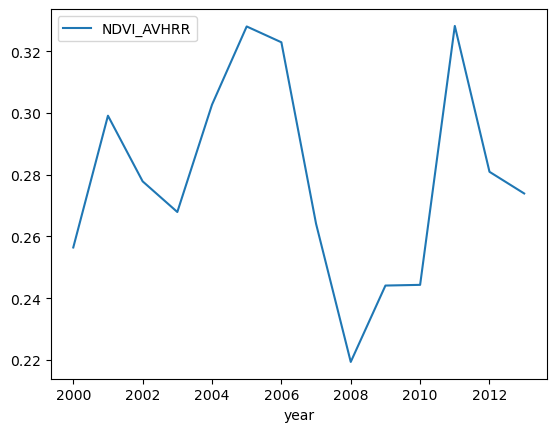

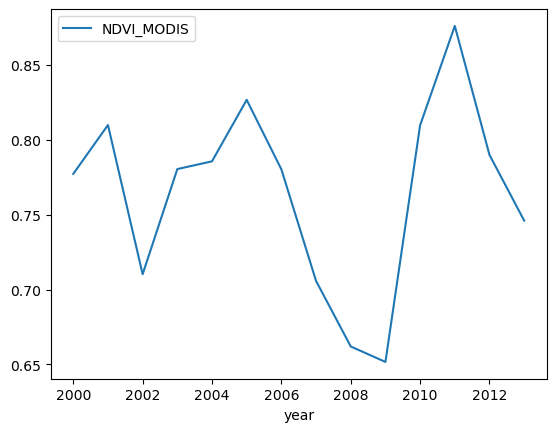

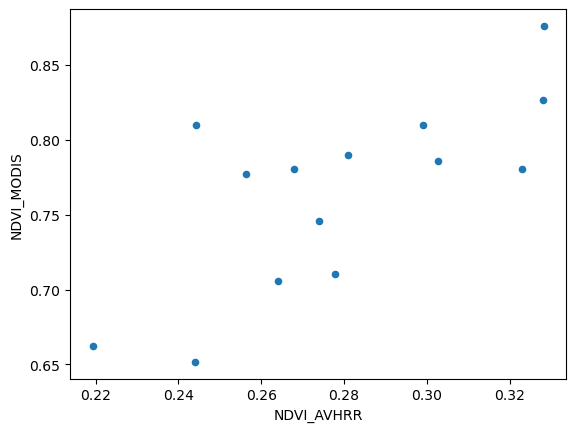

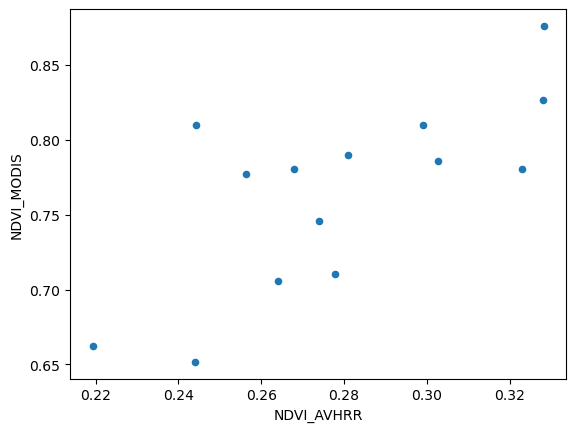

In [61]:
zz=new_df[new_df['UID']=='r1xhh9zyq']
print(zz)
print(r2_score(, zz['NDVI_MODIS']))
zz.plot('year', 'NDVI_AVHRR', kind='line')
zz.plot('year', 'NDVI_MODIS', kind='line')
zz.plot('NDVI_AVHRR', 'NDVI_MODIS', kind='scatter')
zz.plot.scatter(x='NDVI_AVHRR', y='NDVI_MODIS')


# Process Soil Moisture

In [51]:
if soilmoisture_df is None:  #read the data in if required otherwise re-use
    print ('Reading root zone soil moisture data...')
    soilmoisture_df = pd.read_csv(os.path.join(data_path,'ZonalSt30_soilmoistureanomally.csv'))
    soilmoisture_df['year'] = pd.to_datetime(soilmoisture_df['StdTime']).dt.year
    soilmoisture_df = soilmoisture_df.rename(columns = {'MEAN':'soilmoist'})
    
#soil moisture is derived from the soil moisture anomaly data set - use different bins to set scoring _bins=[-1, 0.25, 0.5, 1]
# since the metric is already expressed as an anomally we pass nobaseline = True to prevent calculation of baseline average
                                  
# we pass a subset of metrics that we are interested in to the "calc_pivots" function
#for the BWS project we calculated vegetation stress metrics in a 5year moving window looking at the trend
# (rate and direction of change) within the most recent  the last 2 years
#the summary pivot tables for each metric x aggregator combination are written to the working directory as CSV files                                  
                                  
metrics = ['soilmoist']
calc_pivots (soilmoisture_df, metrics, year_window_width=veg_window_width, trend_window_width=veg_trend_width, _bins=[-1, 0.25, 0.5, 1], reverse_scores=False, nobaseline=True) 

#waterbirds response is faster so windows width =1
calc_pivots (soilmoisture_df, metrics, year_window_width=1, _bins=[-1, 0.25, 0.5, 1], reverse_scores=False, nobaseline=True)


Reading root zone soil moisture data...


soilmoist in 5y window, trend over 2y::   0%|          | 0/34 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - soilmoist_ANAE_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


     Ramsar - soilmoist_Ramsar_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     analogue - soilmoist_analogue_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

soilmoist in 1y window, trend over 1y::   0%|          | 0/38 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - soilmoist_ANAE_1yr.csv
     Ramsar - soilmoist_Ramsar_1yr.csv
     analogue - soilmoist_analogue_1yr.csv


# Process Tree Stand Condition

**input:** average Tree Stand Condition per ANAE polygon per year.  These were calculated using Google Earth Engine (link to code provided in intro). File anaev3_condcol_reduceRegions.csv is processed once in the code below to join the ANAE vegetation type to as input data file **tree_stand_condition.csv**

**output:**  pivot tables for tree condition (redgum blackbox, coolibah) for each spatial aggregation  as CSV files in the working directory

In [52]:
if TSC_df is None:  #read the data in if required otherwise re-use
    print ('Reading Tree Stand Condition data...')
    
    # the first time this was run we joined the ANAE ecosystem type to the TreeStandCondition
    # data in anaev3_condcol_reduceRegions.csv and rewrote the data as tree_stand_condition.csv
    # setting join_wetlands = False skips the join and reads the updated data table
    
    join_wetlands = False
    if join_wetlands:
        TSC_df = pd.read_csv(os.path.join(data_path,'anaev3_condcol_reduceRegions.csv')).set_index('UID')
        TSC_df['year']=(TSC_df['imgIDstart']/10000+1).astype(int)


        ANAE_Tree_subset = ANAE[ANAE['ANAE_TYPE'].str.contains('river red gum|black box|coolibah', case=False)]
        TSC_df=TSC_df.merge(ANAE_Tree_subset, how='inner', left_on='UID', right_on='UID').drop('geometry', axis=1)
        TSC_df.to_csv(os.path.join(TSCpath,'tree_stand_condition.csv'), encoding='utf-8')


    else:
        TSC_df = pd.read_csv(os.path.join(data_path,'tree_stand_condition.csv'))
    
# we pass a subset of metrics that we are interested in to the "calc_pivots" function
#for the BWS project we calculated vegetation stress metrics in a 5year moving window looking at the trend
# (rate and direction of change) within the most recent  the last 2 years
#the summary pivot tables for each metric x aggregator combination are written to the working directory as CSV files    
    
metrics = ['meanTSC']
calc_pivots (TSC_df, metrics, year_window_width = veg_window_width, trend_window_width=veg_trend_width)


Reading Tree Stand Condition data...


meanTSC in 5y window, trend over 2y::   0%|          | 0/31 [00:00<?, ?it/s]

Aggregate metrics and scores:
     ANAE - meanTSC_ANAE_5yr.csv
     Ramsar - meanTSC_Ramsar_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

     analogue - meanTSC_analogue_5yr.csv


[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
[8]:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

# Combine all Vegetation Scores



In [55]:




years = range(alltime[0] + veg_window_width - 1, alltime[-1] + 1)

cond = ['meanTSC', 'npv+pv+wet_median', 'ndvi']
stress = ['water+wet_median', 'time_since_last_inundation', 'SoilMoist']

print (f"""
Condition is the sum of {len(cond)} metrics, {cond}
Stress is the sum of {len(stress)} metrics, {stress}

The scores from saved pivot files in working_directory {working_directory}"

Summed scores for condition and stress are rescaled to range 0-1 to allow for missing data in spatial features

Vulnerability = condition + stress (rescaled 0-1)

A matrix with condition | stress | vulnerability scores is output for each aggregator scale...
""")


#we process all aggregators so vulnerability can be assessed at any of the scales
#for veg the BWS regions are the 'valleys'


for ag in aggregators:
    fname = f"FINAL_BWSVulnerability_vegetation_{ag}.csv"
    print (f"     {ag} - {fname}")
    
    
    '''
        *** CONDITION ***
    '''
    #load in the scores from the condition metric pivot tables that are contributing to the vulnerability score
    cond_a = extract_scores(ag, f"meanTSC_{ag}_5yr.csv", 'scsummeantsc')
    cond_b = extract_scores(ag, f"npv+pv+wet_median_{ag}_5yr.csv", 'scsumnpvpvwet_median')
    cond_c = extract_scores(ag, f"ndvi_{ag}_5yr.csv", 'scsumndvi')
    
    #stacking the three metrics vertically in a df with the same index allows us to use groupby sum and count by index feature
   
    combined_cond_df = pd.concat([cond_a, cond_b, cond_c], axis=0)

    # the condition score is the sum of multiple individual metric scores (nominally three for vegetation in this case)
    # however can be sum of 2-3 metrics if there are missing data resulting in a lower sum.
    # The simple normalise_data function would penailse cells with fewer metrics contributing (thus lower score)
    # Therefore use a revised method that weights by the count of metrics contributing to each sum is used   
    cond_df = sum_and_normalise_data_weighted(combined_cond_df, len(cond)).round(1)
    
    '''
        *** STRESS ***
    '''
    #load in the scores from the stress metric pivot tables that are contributing to the vulnerability score
    stress_a = extract_scores(ag, f"water+wet_median_{ag}_5yr.csv", 'scsumwaterwet_median')
    stress_b = extract_scores(ag, f"time_since_last_inundation_{ag}_vegetation_stress.csv", 'sc_tsli')
    stress_c = extract_scores(ag, f"SoilMoist_{ag}_5yr.csv", 'scsumsoilmoist')

    #stacking the three metrics vertically in a df with the same index allows us to use groupby to sum and count by index feature
    combined_stress_df = pd.concat([stress_a,stress_b,stress_c], axis=0)    

    # the stress score is the sum of multiple individual metric scores (nominally three for vegetation in this case)
    # however can be sum of 1-2 metrics if there are missing data resulting in a lower sum.
    # The simple normalise_data function would penailse cells with fewer metrics contributing (thus lower score)
    # Therefore use a revised method that weights by the count of metrics contributing to each sum is used   
    stress_df = sum_and_normalise_data_weighted(combined_stress_df, len(stress)).round(1)
    
    '''
        *** VULNERABILITY ***
    '''
    
    #vulnerability is condition + stress normalised to range 0-1
    tmp_df = pd.concat([cond_df, stress_df], axis=0)
    vul_df = normalise_data(tmp_df.groupby(tmp_df.index).sum()).round(1)
    
    
    #for compatibility with Excel for user data review having headers that are numbers (i.e. years) cause "issues"
    #rename the columns from numerical years to strings with cond, stress, vul prefix so that Excel treats them as headers
    
    cond_df = cond_df.rename(columns = {c: f"cond{c}" for c in cond_df.columns})
    stress_df = stress_df.rename(columns = {c: f"stress{c}" for c in stress_df.columns})
    vul_df = vul_df.rename(columns = {c: f"vul{c}" for c in vul_df.columns})
    
    
    #append columns for condition, stress and vulnerability scores into a single table
    
    score_df = pd.concat([cond_df, stress_df, vul_df], axis=1)
    score_df.sort_index(axis=1).to_csv(fname)
    
    # NOTE output scale used for vegetaion in the report is Valley scale
    # The relevant output file is FINAL_BWSVulnerability_vegetation_Valley.csv
    
    
    
print("done.")


Condition is the sum of 3 metrics, ['meanTSC', 'npv+pv+wet_median', 'ndvi']
Stress is the sum of 3 metrics, ['water+wet_median', 'time_since_last_inundation', 'SoilMoist']

The scores from saved pivot files in working_directory D:/CSIRO_Ramsar_Climate_Change_Vulnerability/data/output"

Summed scores for condition and stress are rescaled to range 0-1 to allow for missing data in spatial features

Vulnerability = condition + stress (rescaled 0-1)

A matrix with condition | stress | vulnerability scores is output for each aggregator scale...

     ANAE - FINAL_BWSVulnerability_vegetation_ANAE.csv
     Ramsar - FINAL_BWSVulnerability_vegetation_Ramsar.csv
     analogue - FINAL_BWSVulnerability_vegetation_analogue.csv
done.


# Process Waterbirds

In [ ]:

'''
    Read in the data
    
    waterbird count data were indexed/assigned to the nearest aggregator polygon within 1km
    this was done once and the result saved so we dont have to do again.
    If the data is updated add the new waterbird records to waterbirds.shp and switch join_wetlands=TRUE
    to rebuild waterbirds_spatialunits.shp
    
    1km was chosen as a buffer to capture bird observations that are adjacent to polygons
    as the location data isnt very accurate and often bird people record locati
    by GPS which can captures the location of the observer in the carpark rather than
    the actual bird in the wetland
'''
# spatially join the waterbirds to the DIWA and DTwaterbirds aggregator locations one time
# set join_wetlands = True when the waterbirds.shp gets updated to join  any new records

join_wetlands = False

#if we havnt already read in the wb file do it now
if wb is None:
    if join_wetlands:
        waterbirds = gpd.read_file(os.path.join(spatial_path,'waterbirds.shp')).to_crs("EPSG:3577")
        ANAE = gpd.read_file(os.path.join(spatial_path,'ANAEv3_BWS.shp')).to_crs("EPSG:3577")
        DIWA = gpd.read_file(os.path.join(spatial_path,'DIWA_complex.shp')).to_crs("EPSG:3577")
        DTwaterbirds = gpd.read_file(os.path.join(spatial_path,'waterbirds_dirty_thirty.shp')).to_crs("EPSG:3577")

        wb = waterbirds[waterbirds['year']>=1986].copy()
        wb = wb.join(get_nearest_distance(wb, ANAE, 1000, 'ANAE', 'UID'))
        print ("ANAE done")
        #wb = wb.join(get_nearest_distance(wb, ANAE1, 1000, 'ANAE', 'UID'))
        wb = wb.join(get_nearest_distance(wb, DIWA, 1000, 'DIWA', 'WNAME'))
        print ("DIWA done")
        wb = wb.join(get_nearest_distance(wb, DTwaterbirds, 1000, 'DTwaterbirds', 'LABEL'))
        print ("DTwaterbirds done")
        wb.to_file(os.path.join(cwdpath,'wb.shp'), encoding='utf-8')
    else:
        #read in the waterbird data to a geopandas frame
        fname = os.path.join(spatial_path,'waterbirds_spatialunits.shp')
        print (f"Reading in the waterbird data from {fname}")
        wb = gpd.read_file(fname).to_crs("EPSG:3577")
        wb['year']=wb['year'].astype(int) #ensure years are integers

    
# pop1percent is the current estimate for 1% of the world wide population
# Ramsar uses more than 1% being supported at a location as a measure of site significance
# was not used in this project but its here now.
pop1percent = pd.read_csv(os.path.join(data_path,'waterbirds_1_percent.csv'), dtype = {'pop1percent': 'Int64'})
gsrtot = wb.groupby(['grp'])['vName'].nunique()
gsrtot.name='maxGrp'

In [ ]:
#handy check we're reading in all the right data
wb['iCount'].sum()
#total number of all waterbirds - as of 8/8/2022 this is 55837052.6731643

In [ ]:
'''
 calculate the total indivduals and species richness per aggregating polygon scale
 Waterbirds obseevations per ANAE polygon are aggregated to DIWA and the 'Dirty Thirty' MDBA Waterbirds Areas
 
 naming convention
 
 prefixes
 
 i = number of individuals per species  for each spatial unit
 gi = number of individuals in each functional group (summing all species in the group) for each spatial unit
 sr = total species richness for each spatial unit
 gsr = group species richness  for each spatial unit
 
 
 suffix
 
 breed =  breeding records only
'''


#create a bunch of data frames holding the sumamry metrics
# waterbird_metrics converts observation data to popn estimates

iDIWA, giDIWA, srDIWA, gsrDIWA = waterbird_metrics(wb, 'DIWA_name')

iDT, giDT, srDT, gsrDT = waterbird_metrics(wb, 'DT_name')

breeding = wb[wb['Breeding'] > 0]

iDIWAbreed, giDIWAbreed, srDIWAbreed, gsrDIWAbreed = waterbird_metrics(breeding, 'DIWA_name', 'breeding')
iDTbreed, giDTbreed, srDTbreed, gsrDTbreed = waterbird_metrics(breeding, 'DT_name', 'breeding')

In [ ]:


def writepivot (series, name):
    
    '''
        across the waterbird year data calculate data summaries as:
        count =  number of years with waterbird counts
        max = maximum annual abundance/richness for baseline period
        median = median value for baseline period
        mad =  median absolute deviation
               mad is a robust non-parametric measure of central tendency used as the 'baseline' estimate with the
               waterbird data because there are lots of spatial units with no or few count records
        cmadYYYY = the annual MAD condition (deviation from the baseline)
        
        sc_cmadYYYY =  binned score [1,2,3] 1 = more than 1 deviation below baseline, 2= between -1 and 0, 3 = deviation above baseline
        
        Significance Criteria (optional)
        --------------------------------
        The following metrics were explorered as ways to assess significance but
        in the end were not used. They are retained in the output tables for future reference
        The report instead applied HEVAE critiera to assess importance.
        
        gt1pop_all = number of years total count exceeds 1% of the world population
        gt1pop_recent = number of years total count exceeds 1% of the world population in recent period - (defined as last 5 years of the baseline period currently)
        grpHistImp = number of years group represented at a location compared to the maximum representation in the whole data set
        grpReliability = reliability of presence of group at location as proportion of years that the group is represented
        YYYYgrpImp = annual reliability as proportion of maximum for the group
        
    '''
    #waterbirds shapefile uses differnet naming for the DIWA and DT wetlands compared to the aggfield
    #need to rename the waterbird grouping columns to match the aggfields names so the waterbird data can easily be matched
    #to the vegetation habitat stress metrics WIT, TSC and NDVI etc
    series.index.rename({'DT_name':aggfield['DTwaterbirds'][0], 'DIWA_name':aggfield['DIWA'][0]}, inplace=True)
    
    #summed aggregate area per spatial unit needed to to area weighting if a waterbird group is spread across more than one habitat types (Cryptic waders)
    area = aggregators[ag][['Area_Ha']+['grp']+aggfield[ag]].groupby(aggfield[ag]+['grp']).sum()
    
    pkey = []
    pkey = list(x for x in list(series.index.names) if x != 'year')

    pivot = pivot_year(pd.DataFrame(series).reset_index(), series.name, pkey)
    
    for y in alltime:
        #calculate condition measures in each year as deviation from baseline (median) stndardised by the MAD
        pivot[f"cmad{y}"] = pivot[y].subtract(pivot['median']).divide(pivot['mad'].replace({0:1}))
        #note: species richess does not alwys vary much so replacing MAD=zero with 1 just for these few records prevents div/zero errors
        #and allows retention of missing numerator condition data


    #score the condition measures from 1-3  where 1 = more than 1 deviation below, 2= between -1 and 0, 3 = any positive deviation
    _bins=[float('-inf'),-1,0,float('inf')]
    _scores = list(range(1,len(_bins)))
    cols = [f"cmad{y}" for y in alltime]
    #scores are appended as additonal columns to the right with an 'sc' prefix on the column names
    pivot = append_metric_scores(pivot, cols, _bins, _scores)

  
    # activate or deactivate the additon of these significane criteria
    # these were explored but ultimately not used in the project which adopted HEVAE criteria instead
    # code left here for prosperity
    addSignificantCriteria = False
    if addSignificantCriteria:
        if 'vName' in pivot.index.names:
            pivot = pivot.join(pop1percent.set_index(['vName'])['pop1percent'], on='vName')
            for y in alltime:
                pivot[f"{y}prop1pop"] = pivot[y]/pivot['pop1percent']
            #build true-false array - sum=count of true
            tmp = pd.DataFrame()
            for y in alltime:
                tmp[y]=pivot[y]>pivot['pop1percent']
            pivot['gt1pop_all'] = tmp.sum(axis=1, numeric_only=True)
            pivot['gt1pop_recent'] = tmp[recent].sum(axis=1, numeric_only=True)


        elif 'grp' in pivot.index.names and 'sr' in name:

            #for species richess condition uses median absolute deviation (mad)

            pivot = pivot.join(gsrtot, on='grp')
            pivot['grpHistImp'] = pivot['max']/pivot['maxGrp']
            pivot['grpReliability'] = pivot['count']/len(alltime)
            for y in alltime:
                pivot[f"{y}grpImp"] = pivot[y]/pivot['maxGrp']
            tmp = pd.DataFrame()
   
    pivot.to_csv(f"waterbird_{name}_cmad.csv")
    return pivot

# write out all the pivot tables containing condition metrics and score at various scales for different data subsets
# saved as csv so they can easily be inspected in Excel

writepivot (iDIWA, 'iDIWA')
writepivot (giDIWA, 'giDIWA')
writepivot (srDIWA, 'srDIWA')
writepivot (gsrDIWA, 'gsrDIWA')
writepivot (iDT, 'iDTwaterbirds')
writepivot (giDT, 'giDTwaterbirds')
writepivot (srDT, 'srDTwaterbirds')
writepivot (gsrDT, 'gsrDTwaterbirds')
writepivot (iDIWAbreed, 'iDIWA_breed')
writepivot (giDIWAbreed, 'giDIWA_breed')
writepivot (srDIWAbreed, 'srDIWA_breed')
writepivot (gsrDIWAbreed, 'gsrDIWA_breed')
writepivot (iDTbreed, 'iDTwaterbirds_breed')
writepivot (giDTbreed, 'giDTwaterbirds_breed')
writepivot (srDTbreed, 'srDTwaterbirds_breed')
writepivot (gsrDTbreed, 'gsrDTwaterbirds_breed')


writepivot (iDT.groupby(['year', 'grp', 'vName']).sum(), 'iBasin')
writepivot (iDT.groupby(['year', 'grp']).sum(), 'giBasin')
writepivot (iDTbreed.groupby(['year', 'grp', 'vName']).sum(), 'iBasin_breed')
writepivot (iDTbreed.groupby(['year', 'grp']).sum(), 'giBasin_breed')

#writepivot (wb.groupby(['year'])['vName'].nunique(), 'srBasin')
writepivot (wb.groupby(['year', 'grp'])['vName'].nunique(), 'gsrBasin')
#writepivot (breeding.groupby(['year', 'grp', 'vName'])['vName'].nunique(), 'srBasinbreed')
writepivot (breeding.groupby(['year','grp'])['vName'].nunique(), 'gsrBasin_breed')
print ('done')


In [ ]:
years = alltime
#condition of waterbirds is per group at Basin scale based on
# species richness, abundance, species breeding, breeding abundance
cond = ['gsrBasin', 'giBasin', 'gsrBasinbreed', 'giBasinbreed']

stress = ['water+wet_median', 'time_since_last_inundation', 'SoilMoist', 'pv']

print (f"""
    Waterbird condition is the sum of {len(cond)} metrics, {cond}
    Stress is the sum of {len(stress)} metrics, {stress}
    
    The scores from saved pivot files in working_directory {working_directory}"

    Summed scores for condition and stress are rescaled to range 0-1 to allow for missing data in spatial features

    Vulnerability = condition + stress / 2

    A matrix with condition | stress | vulnerability scores is output for each aggregator scale...
    """)


# we process all aggregators so vulnerability can be assessed at any of the scales
# for veg the BWS regions are the 'valleys' but for waterbirds its 'Basin'
# we process the DTwaterbirds and DIWA also to inform more site specific inquiry

wbaggregators = ['Basin', 'DIWA', 'DTwaterbirds']


for ag in wbaggregators:
    fname = f"FINAL_BWSVulnerability_waterbirds_{ag}.csv"
    print (f"     {ag} - {fname}")
    
    
    '''
        *** CONDITION ***
    '''
    #load in the scores from the condition metric pivot tables that are contributing to the vulnerability score
    cond_a = extract_scores(ag, f'waterbird_gsr{ag}_cmad.csv', 'sccmad')
    cond_b = extract_scores(ag, f'waterbird_gi{ag}_cmad.csv', 'sccmad')
    cond_c = extract_scores(ag, f'waterbird_gsr{ag}_breed_cmad.csv', 'sccmad')
    cond_d = extract_scores(ag, f'waterbird_gi{ag}_breed_cmad.csv', 'sccmad')
    
    
    #write the final condition scores aligned to waterbird groups to files so we can colour them up in Excel for the report
    cond_a.to_csv(f'waterbird_{ag}_CONDITION_1_gsr.csv')  
    cond_b.to_csv(f'waterbird_{ag}_CONDITION_2_gi.csv')
    cond_c.to_csv(f'waterbird_{ag}_CONDITION_3_gsr_breed.csv')
    cond_d.to_csv(f'waterbird_{ag}_CONDITION_4_gi_breed.csv')
    
    
    #stacking the 4 metrics vertically in a df with the same index allows us to use groupby sum and count by index feature
    combined_cond_df = pd.concat([cond_a, cond_b, cond_c, cond_d], axis=0)
    
    # the condition score is the sum of multiple individual metric scores (nominally four for waterbirds in this case)
    # however can be sum of 2-3 metrics if there are missing data resulting in a lower sum.
    # The simple normalise_data function would penailse cells with fewer metrics contributing (thus lower score)
    # Therefore use a revised method that weights by the count of metrics contributing to each sum is used
    cond_df = sum_and_normalise_data_weighted(combined_cond_df, len(cond)).round(1)
    
    
    '''
        *** STRESS ***
    '''
    #load in the scores from the stress metric pivot tables that are contributing to the vulnerability score
    stress_a = habitat_to_waterbird_groups (ag, extract_scores(ag, f'water+wet_median_{ag}_1yr.csv', 'scwaterwet_median'))
    stress_b = habitat_to_waterbird_groups (ag, extract_scores(ag, f'time_since_last_inundation_{ag}_waterbird_habitat_stress.csv', 'sc_tsli'))
    stress_c = habitat_to_waterbird_groups (ag, extract_scores(ag, f'soilmoist_{ag}_1yr.csv', 'scsoilmoist'))
    stress_d = habitat_to_waterbird_groups (ag, extract_scores(ag, f'pv_median_{ag}_1yr.csv', 'scpv_median'))

    #write the final stress scores aligned to waterbird groups to files so we can colour them up in Excel for the report
    stress_a.to_csv(f'waterbird_{ag}_STRESS_1_water+wet_median.csv')
    stress_b.to_csv(f'waterbird_{ag}_STRESS_2_sc_tsli.csv')
    stress_c.to_csv(f'waterbird_{ag}_STRESS_3_soilmoist.csv')
    stress_d.to_csv(f'waterbird_{ag}_STRESS_4_pv_median.csv')

    #stacking the 4 metrics vertically in a df with the same index allows us to use groupby to sum and count by index feature
    combined_stress_df = pd.concat([stress_a, stress_b, stress_c, stress_d], axis=0)    

    # the stress score is the sum of multiple individual metric scores (nominally four for waterbirds in this case)
    # however can be sum of 2-3 metrics if there are missing data resulting in a lower sum.
    # The simple normalise_data function would penailse cells with fewer metrics contributing (thus lower score)
    # Therefore use a revised method that weights by the count of metrics contributing to each sum is used   
    stress_df = sum_and_normalise_data_weighted(combined_stress_df, len(stress)).round(1)

    
    '''
        *** VULNERABILITY ***
    '''
    
    #vulnerability is condition + stress normalised to range 0-1
    tmp_df = pd.concat([cond_df, stress_df], axis=0)
    vul_df = normalise_data(tmp_df.groupby(tmp_df.index).sum()).round(1)
    
    
    #for compatibility with Excel for user data review having headers that are numbers (i.e. years) cause "issues"
    #rename the columns from numerical years to strings with cond, stress, vul prefix so that Excel treats them as headers
    
    cond_df = cond_df.rename(columns = {c: f"cond{c}" for c in cond_df.columns})
    stress_df = stress_df.rename(columns = {c: f"stress{c}" for c in stress_df.columns})
    vul_df = vul_df.rename(columns = {c: f"vul{c}" for c in vul_df.columns})
    
    
    #right-append columns for overall condition, overall stress and vulnerability into a single table
    score_df = pd.concat([cond_df, stress_df, vul_df], axis=1)
    score_df.sort_index(axis=1).to_csv(fname)
    
    # NOTE output scale used for waterbirds in the report is Basin scale
    # The relevant output file is FINAL_BWSVulnerability_waterbirds_Basin.csv
    
print("All done.")

In [ ]:
df['financial_year'] = df['base_date'].map(lambda d: d.year + 1 if d.month > 6 else d.year)